# Timeseries Forecast and Classification for Energy case

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn statsmodels tensorflow sktime wildboar numba darts

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

import sklearn
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from wildboar.distance import matrix_profile
from wildboar import annotate
from multiprocessing import Pool

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# For N-BEATS
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, rmse, mape
# For ROCKET
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit


In [3]:
# Setting random seed

import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the dataset and check missing value

The dataset is taken from [Open Power System Data](https://data.open-power-system-data.org/time_series/). The timeframe of the dataset is between 1st January 2015 and 30th September 2020.

This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity prices, electricity consumption (load) as well as wind and solar power generation and capacities. The data is aggregated either by country (*in this case we took only for Sweden*), control area or bidding zone. All variables are provided in hourly resolution.

**Variables:**
- SE_load_actual_entsoe_transparency:	Total load in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_load_forecast_entsoe_transparency:	Day-ahead load forecast in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_wind_capacity: Electrical capacity of wind in Sweden in MW	own calculation based on Vindbrukskollen
- SE_wind_offshore_capacity: Electrical capacity of wind_offshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_capacity: Electrical capacity of wind_onshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_generation_actual: Actual wind_onshore generation in Sweden in MW	ENTSO-E Transparency

**Bidding zone:**
Sweden's bidding zones in the electricity market are divided into:
- SE_1: Northern Sweden (lowest population, lots of hydro/wind generation)
- SE_2: Central Sweden
- SE_3: Southern Sweden (including Stockholm area)
- SE_4: Southernmost Sweden (including Malmö, connects to Denmark)

Each zone can have different electricity prices due to transmission constraints.

In this notebook, we'll be focusing on SE_3 data (individual zone) for better insights. The reason to keep the individual zones are:
- Different price dynamics: Each zone has different price patterns
- Regional load patterns: SE_3 (urban) vs SE_1 (industrial) have very different consumption
- Better model performance: Models can learn zone-specific patterns
- More realistic: Real electricity markets operate at zone level

In [4]:
df = pd.read_csv('data/time_series_60min_singleindex_filtered.csv')[[
    'utc_timestamp',
    'SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead',
    'SE_3_wind_onshore_generation_actual']]

In [5]:
# Ensure the data is in the right format
df[['SE_3_load_actual_entsoe_transparency',
'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']] = df[['SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']].astype(float)

df.rename(columns = {
    'SE_3_load_actual_entsoe_transparency':'load_actual',
    'SE_3_price_day_ahead':'price',
    'SE_3_wind_onshore_generation_actual':'load_generation'
}, inplace=True)

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], errors='coerce')
df.set_index('utc_timestamp', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   load_actual      50321 non-null  float64
 1   price            50386 non-null  float64
 2   load_generation  50303 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


<Axes: xlabel='utc_timestamp'>

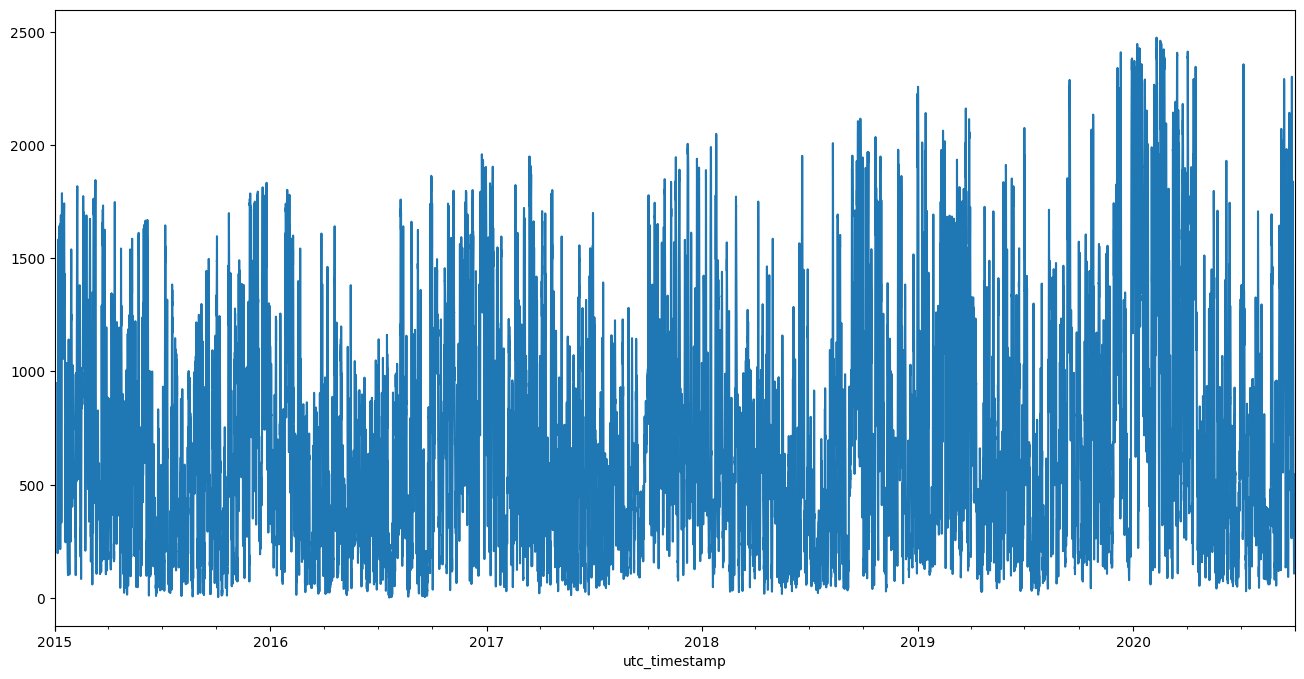

In [6]:
df['load_generation'].plot(figsize=(16,8))

<Axes: xlabel='utc_timestamp'>

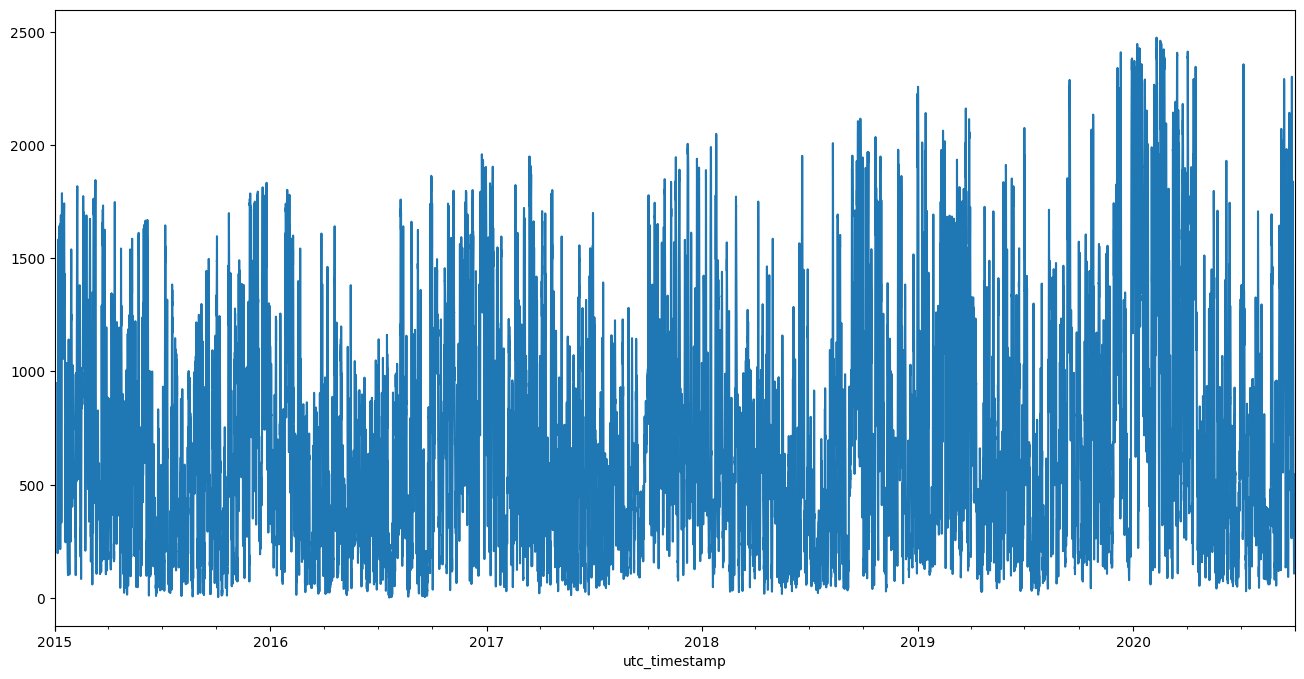

In [7]:
df['load_generation'].plot(figsize=(16,8))

<Axes: xlabel='utc_timestamp'>

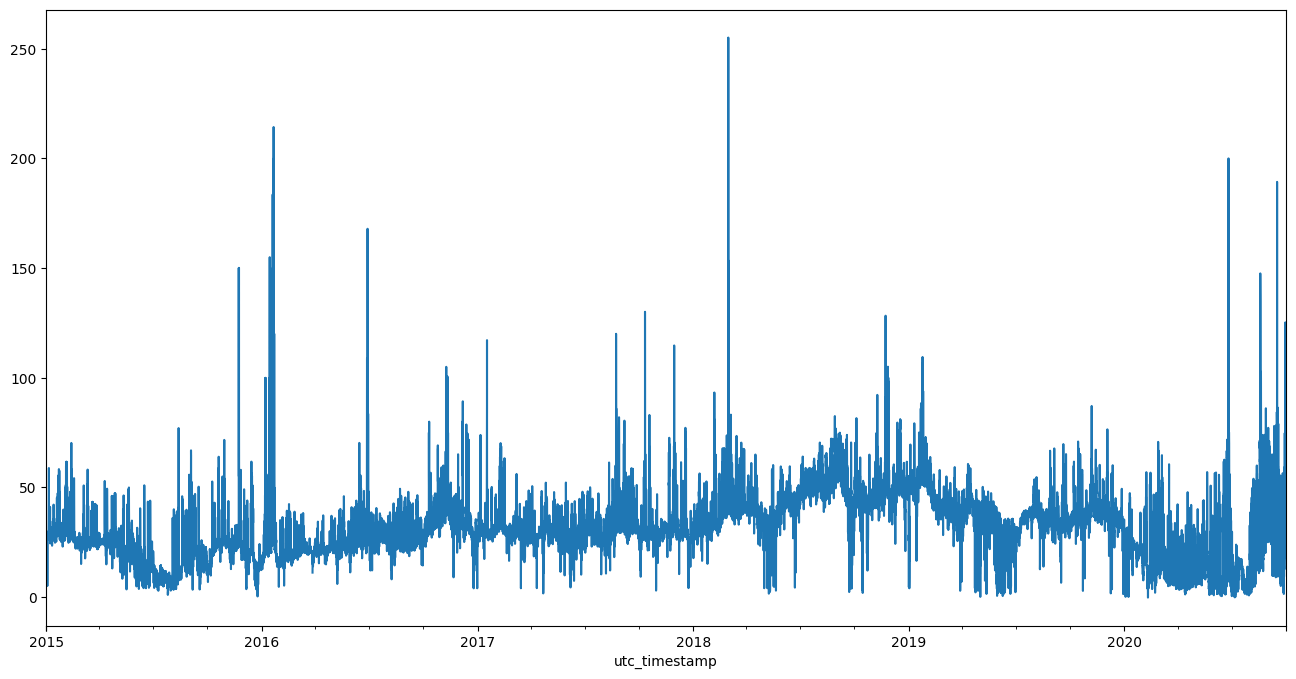

In [8]:
df['price'].plot(figsize=(16,8))

In [9]:
print("Missing value count")
print(df.isnull().sum())

Missing value count
load_actual        80
price              15
load_generation    98
dtype: int64


In [10]:
print("Missing value per columns")
print((df.isnull().mean()*100).round(3))

Missing value per columns
load_actual        0.159
price              0.030
load_generation    0.194
dtype: float64


In [11]:
for col in df.columns:
    na_blocks = df[col].isna().astype(int).groupby(df[col].notna().astype(int).cumsum()).sum()
    print(f"\nMissing blocks in {col}")
    print(na_blocks[na_blocks > 0])

# Interpretation:
# -. The tendency of missing values is a few very small gaps (likely hours)
# -. One moderate gap: 49 consecutive missing points (~ 2days)
# -. One big gap: 97 consecutive missing points (in the beginning, trim)


Missing blocks in load_actual
load_actual
0         2
1788     10
6724      7
6737     11
8249     49
50321     1
Name: load_actual, dtype: int64

Missing blocks in price
price
0        2
2089     2
10823    2
19557    2
28291    2
37193    2
45927    2
50386    1
Name: price, dtype: int64

Missing blocks in load_generation
load_generation
0        97
50303     1
Name: load_generation, dtype: int64


## EDA + Feature Engineering

In [7]:
df_imp = df.copy()

def impute_ts(df):
    # Imputation of Missing Value
    max_gap_hours = 6
    period=24*7

    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Process each gap
            # print(f"Original dataset: {df[column].isnull().sum()}")

            i = 0
            missing_mask = df[column].isnull()

            while i < len(missing_mask):
                if missing_mask.iloc[i]:
                    gap_start = i # start of the gap
                    gap_end = i # end of the gap
                    while gap_end < len(missing_mask) - 1 and missing_mask.iloc[gap_end + 1]:
                        gap_end += 1

                    gap_length_hours = gap_end - gap_start + 1

                    # STEP 1: Short gaps - Linear interpolation
                    if gap_length_hours <= max_gap_hours:
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"After interpolation {i}: {df[column].iloc[gap_start:gap_end+1].isnull().sum()} NaNs")

                    # STEP 2: Medium gaps - Weekly pattern matching
                    else:
                        for j in range(gap_start, gap_end + 1):
                            current_time = df[column].index[j]

                            # Look for same time in previous three weeks
                            for weeks_back in [1, 2, 3]:
                                past_time = current_time - pd.Timedelta(weeks=weeks_back)
                                if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                    df[column].iloc[j] = df[column].loc[past_time]
                                    break

                            # If it didn't work, use daily pattern
                            if pd.isna(df[column].iloc[j]):
                                for days_back in [1, 2, 3, 7]:
                                    past_time = current_time - pd.Timedelta(days=days_back)
                                    if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                        df[column].iloc[j] = df[column].loc[past_time]
                                        break

                        # Fill any remaining with interpolation
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"Final interpolation : {df[column].iloc[gap_start:gap_end+1].isnull().sum()}")

                    i = gap_end + 1
                else:
                    i += 1

        # For the remaining NaNs
        try:
            decomposition = seasonal_decompose(df[column].dropna(), model='additive', period=period)
            trend = decomposition.trend.reindex(df[column].index)
            seasonal = decomposition.seasonal.reindex(series.index)

            missing_mask = df[column].isnull()
            for idx in df[column][missing_mask].index:
                if pd.notna(trend.loc[idx]) and pd.notna(seasonal.loc[idx]):
                    df[column].loc[idx] = trend.loc[idx] + seasonal.loc[idx]

            df[column] = df[column].interpolate()

        except Exception as e:
            df[column] = df[column].interpolate()

    return df

In [8]:
df_imp = impute_ts(df_imp)

In [9]:
# [BOUNDARY/ISOLATED CASES]: Remove problematic start period because the missing values are concentrated in the beginning of the data
first_valid_date = max(df_imp[col].first_valid_index() for col in df_imp.columns)
df_imp = df_imp.loc[first_valid_date:]

In [10]:
print(df_imp.isnull().sum())

load_actual        0
price              0
load_generation    0
dtype: int64


### Parameter Setting

For the following analysis (check stationary, matrix profile, motif discovery and so on whenever possible), you need to set a single variable that will be used multiple times.

Daily cycles: win = 24 --> Captures 1 full day
Multi-day cycles (weekend vs weekday): win = 24 * 7 = 168 --> Captures weekly structure
Seasonal templates (summer/winter): win = 24 * 30 ≈ 720 --> Captures monthly patterns
Load ramp patterns (morning/evening increase/decrease): win = 6–12 --> Shorter windows focus on ramp-up / ramp-down
Holiday / maintenance periods: win 24–168 -->Depends if anomaly is daily or spans a week

In [16]:
win = 24*7
lag = 30 # for check stationary, define the lag
win = 24*7 # period of recurring pattern (could be day, month, season)
exc = 0.2 # for matrix profile calc, avoid trivial matches (comparing a time period to itself or immediate neighbors)

### Check stationary

Investigate stationarity by:
- using a rolling mean and standard deviation: if both stay "approximately" constant over time the time series is likely stationary
- using a stationarity test such as Augmented Dickey-Fuller test
- by investing the auto-correlation for different time *lags*.

In [17]:
def test_stationary(x, window=win, lags=lag):
    """Check stationarity using rolling statistics, ACF, and ADF test
    - rolling statistics: take a window and compute the mean and stdev within the window, then move on the window one time step
    - autocorrelation: how much the correlation between a time series and its lagged version of it
    lags: how many lagged version do we need to compute? showing by the number of bar represent in the chart
    - adf test: if ADF < 1%, 5%, 10% AND p-value < 1% --> reject H0 (non-stationary) --> this means the TS is stationary

    """

    roll_mean = x.rolling(window=window).mean()
    roll_std = x.rolling(window=window).std()

    fig, ax = plt.subplots(2, 1, figsize=(16, 12))

    # Rolling mean and std
    ax[0].plot(x, label="Original")
    ax[0].plot(roll_mean, label="Mean", linestyle='dashed')
    ax[0].plot(roll_std, label="Std Dev", linestyle='dotted')
    ax[0].legend()
    ax[0].set_title(f"Stationarity {x.name}: rolling mean and std dev, window={window}")

    # ACF plot
    plot_acf(x, lags=lags, ax=ax[1])
    ax[1].set_title(f"Stationarity ACF Plot {x.name}: Autocorrelation for lags={lags}")

    result = adfuller(x)
    print(f"ADF Test Results:{x}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")

    return fig, ax

ADF Test Results:utc_timestamp
2015-01-05 00:00:00+00:00    10406.0
2015-01-05 01:00:00+00:00    10281.0
2015-01-05 02:00:00+00:00    10293.0
2015-01-05 03:00:00+00:00    10418.0
2015-01-05 04:00:00+00:00    10850.0
                              ...   
2020-09-30 19:00:00+00:00     9293.0
2020-09-30 20:00:00+00:00     8591.0
2020-09-30 21:00:00+00:00     8030.0
2020-09-30 22:00:00+00:00     7648.0
2020-09-30 23:00:00+00:00     7648.0
Name: load_actual, Length: 50304, dtype: float64
ADF Statistic: -7.6770
p-value: 0.0000
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity load_actual: rolling mean and std dev, window=168'}>,
        <Axes: title={'center': 'Stationarity ACF Plot load_actual: Autocorrelation for lags=30'}>],
       dtype=object))

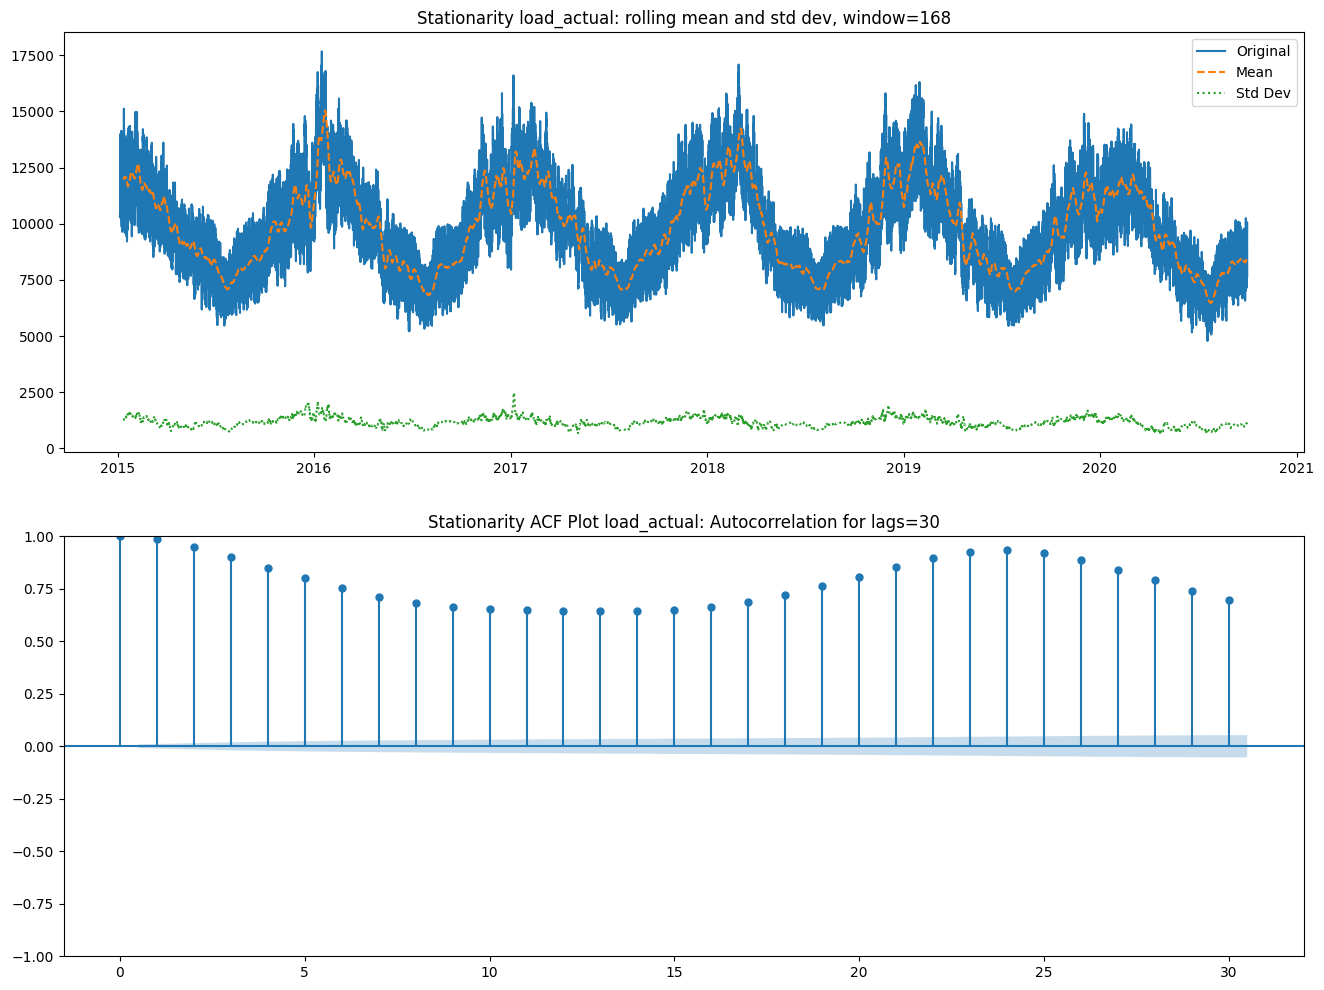

In [18]:
test_stationary(df_imp['load_actual'])

# Interpretation: the timeseries is stationary, differencing is not needed.

ADF Test Results:utc_timestamp
2015-01-05 00:00:00+00:00    28.88
2015-01-05 01:00:00+00:00    28.87
2015-01-05 02:00:00+00:00    28.97
2015-01-05 03:00:00+00:00    29.34
2015-01-05 04:00:00+00:00    30.33
                             ...  
2020-09-30 19:00:00+00:00    31.48
2020-09-30 20:00:00+00:00    28.94
2020-09-30 21:00:00+00:00    24.08
2020-09-30 22:00:00+00:00    17.85
2020-09-30 23:00:00+00:00    17.85
Name: price, Length: 50304, dtype: float64
ADF Statistic: -9.8224
p-value: 0.0000
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity price: rolling mean and std dev, window=168'}>,
        <Axes: title={'center': 'Stationarity ACF Plot price: Autocorrelation for lags=30'}>],
       dtype=object))

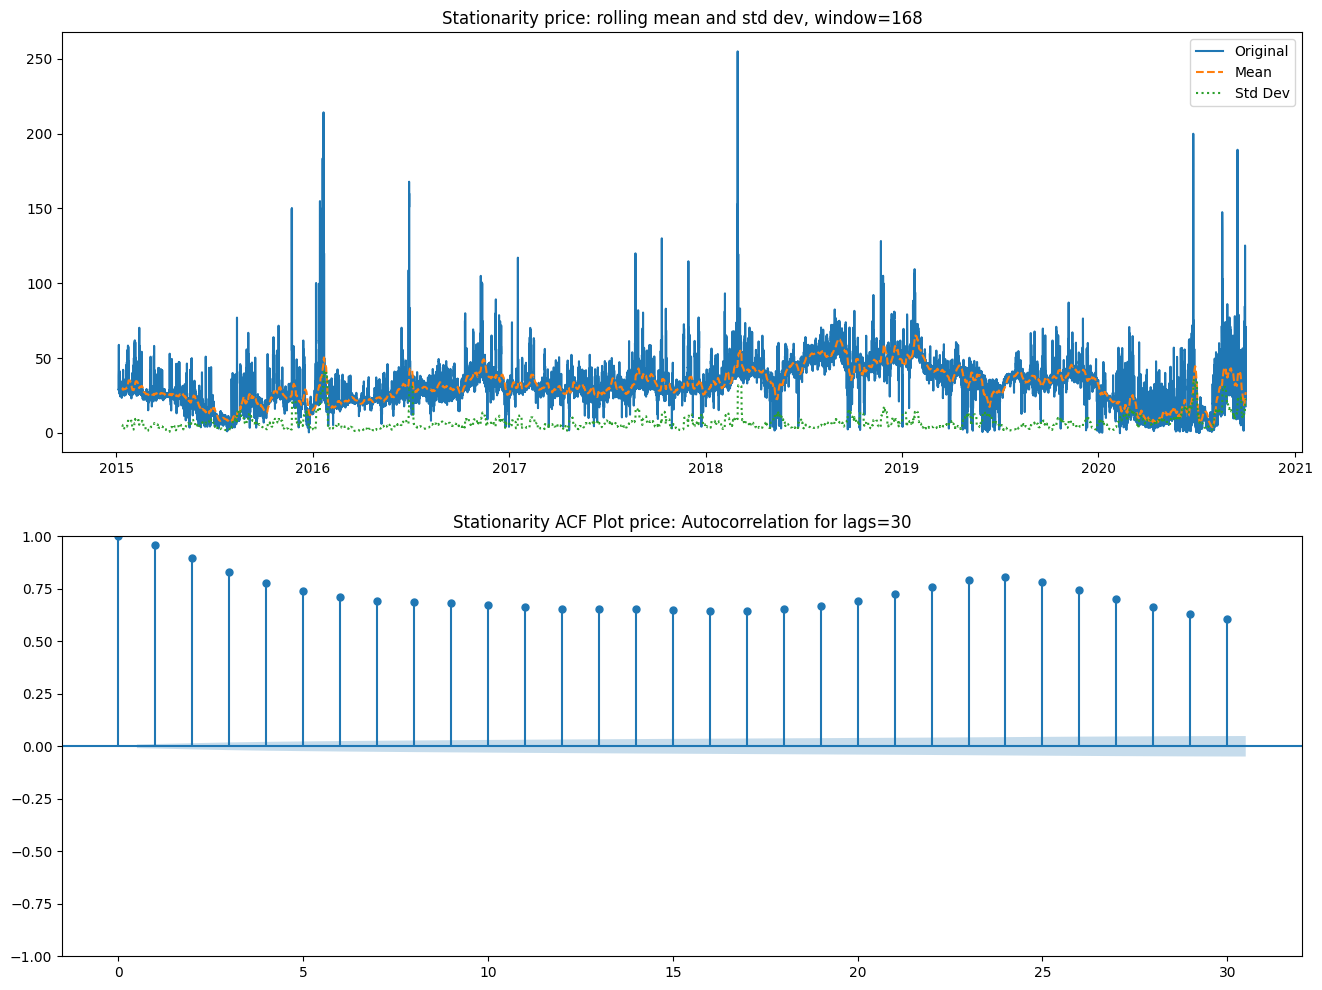

In [19]:
test_stationary(df_imp['price'])

# Interpretation: the timeseries is stationary, differencing is not needed.

ADF Test Results:utc_timestamp
2015-01-05 00:00:00+00:00    949.0
2015-01-05 01:00:00+00:00    902.0
2015-01-05 02:00:00+00:00    842.0
2015-01-05 03:00:00+00:00    782.0
2015-01-05 04:00:00+00:00    712.0
                             ...  
2020-09-30 19:00:00+00:00    503.0
2020-09-30 20:00:00+00:00    533.0
2020-09-30 21:00:00+00:00    548.0
2020-09-30 22:00:00+00:00    507.0
2020-09-30 23:00:00+00:00    507.0
Name: load_generation, Length: 50304, dtype: float64
ADF Statistic: -17.4105
p-value: 0.0000
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity load_generation: rolling mean and std dev, window=168'}>,
        <Axes: title={'center': 'Stationarity ACF Plot load_generation: Autocorrelation for lags=30'}>],
       dtype=object))

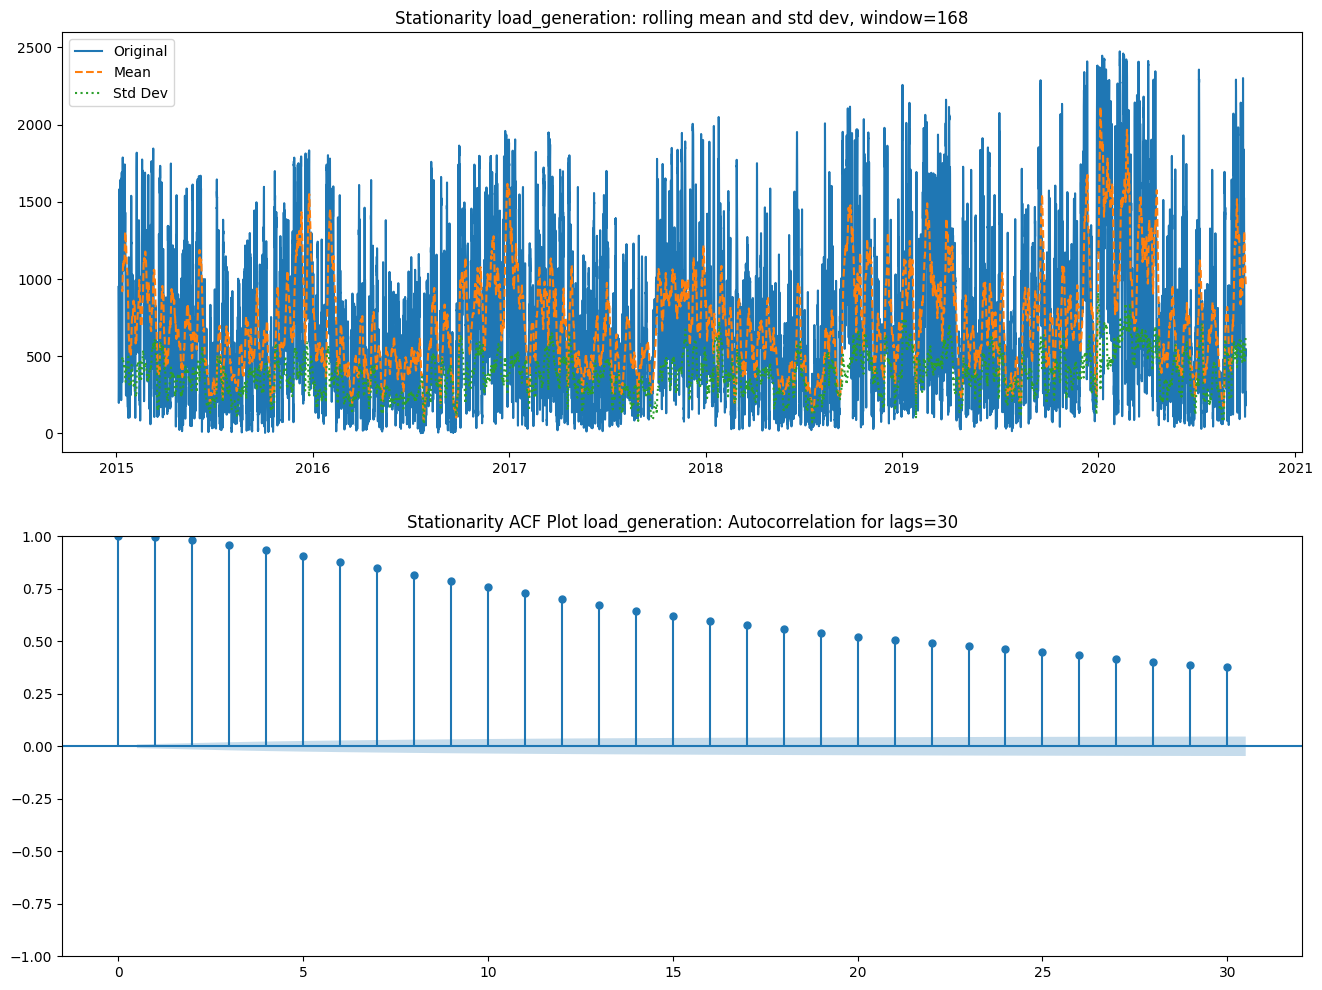

In [20]:
test_stationary(df_imp['load_generation'])

# Interpretation: the timeseries is stationary, differencing is not needed.

### Decomposition

In [21]:
def decompose_series(x, model='additive', period=win):
    """Decompose the series into trend, seasonality, and residuals."""

    decomposition = seasonal_decompose(x, model=model, period=period)

    fig, ax = plt.subplots(nrows=4, figsize=(12, 12))

    ax[0].plot(x.index, x)
    ax[0].set_ylabel("Original")
    ax[1].plot(decomposition.trend)
    ax[1].set_ylabel("Trend")
    ax[2].plot(decomposition.seasonal)
    ax[2].set_ylabel("Seasonality")
    ax[3].plot(decomposition.resid)
    ax[3].set_ylabel("Residuals")
    fig.tight_layout()
    return fig, ax

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

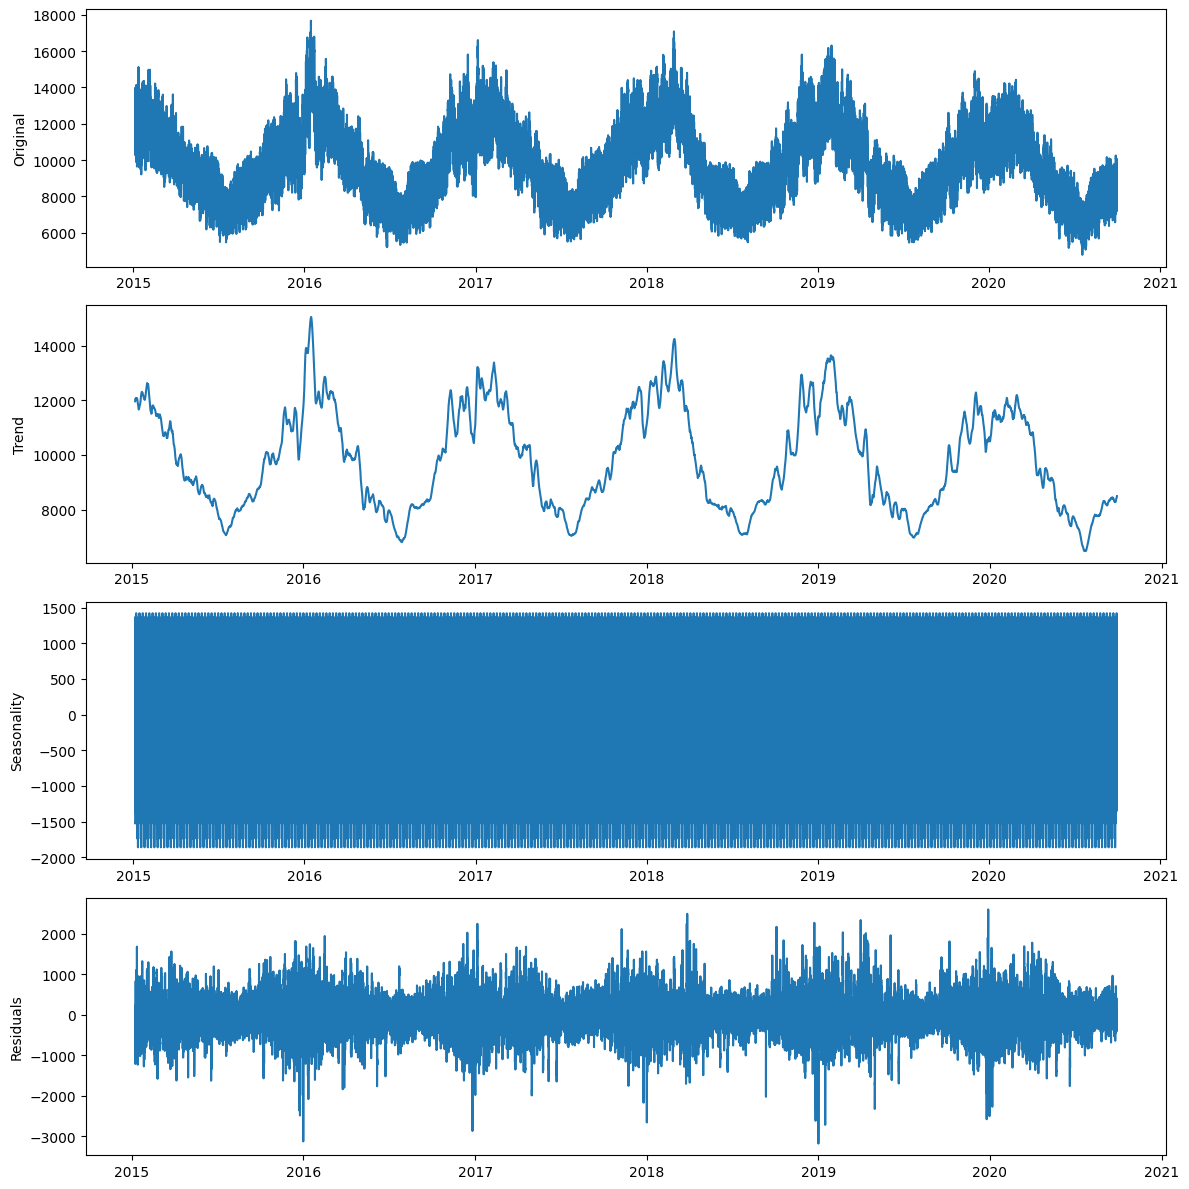

In [22]:
decompose_series(df_imp['load_actual'])

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

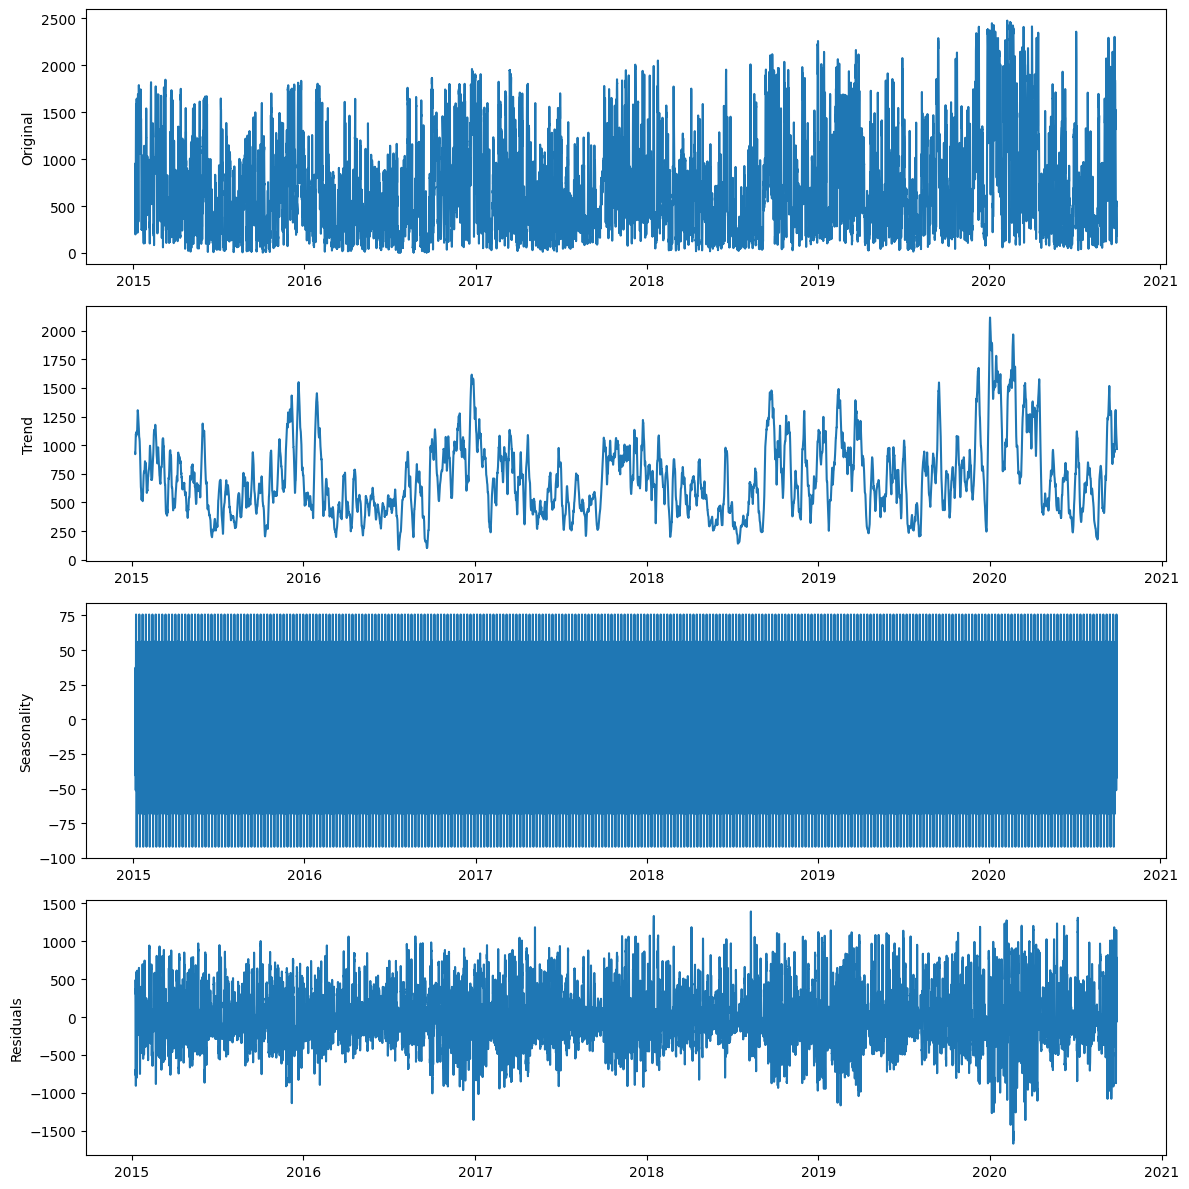

In [23]:
decompose_series(df_imp['load_generation'])

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

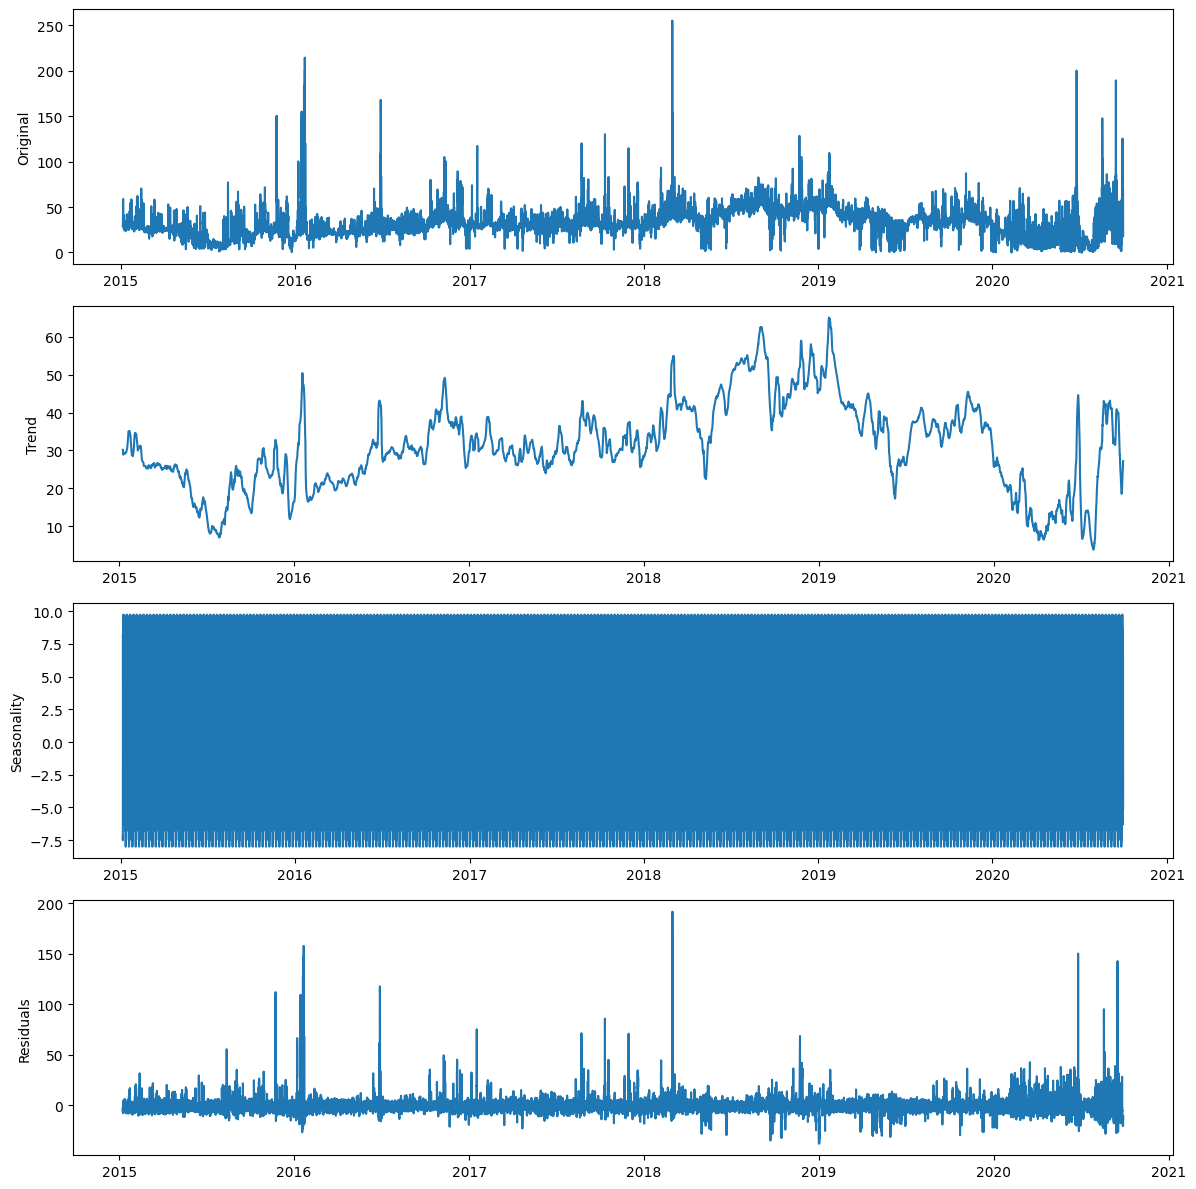

In [24]:
decompose_series(df_imp['price'])

### Matrix Profile using MASS for faster implementation

It helps us to understand:
- recurring daily patterns: which days had similar load curve
- seasonal similarities: find similar weeks/months across different year
- anomaly detection: high matrix profile value = unusual periods with no similar pattern
- pattern stability: low values = recurring, predictable patterns

Two parts represent: <br>
-. minimum distance of every possible query of window size <br>
-. index of the time series with the closest counterparts. <br>


In [25]:
def compute_matrix_profile(x, window=win, exclude=exc, return_index=True, top_k=5):
    start = time.time()
    mp, mp_idx = matrix_profile(x, window=window, exclude=exclude, return_index=True)

    fig, ax= plt.subplots(2, figsize=(16,12))
    ax[0].plot(mp)
    ax[0].set_title("Matrix Profile")
    ax[1].plot(x.index, x.values, label="Original", color='gray', alpha=0.7)

    # Find most recurring patterns (lowest MP values)
    min_idx = np.argsort(mp)[:top_k]  # Top 5 most similar patterns

    colors = ["red", "green", "orange", "purple", "blue"]
    print(f"Most recurring patterns (lowest distances):")

    for j, idx in enumerate(min_idx):
        if not np.isnan(mp[idx]):
            partner_idx = mp_idx[idx]
            pattern_time = x.index[idx]
            partner_time = x.index[partner_idx]

            pattern_time_num = mdates.date2num(pattern_time)
            partner_time_num = mdates.date2num(partner_time)

            time_width = mdates.date2num(pattern_time + pd.Timedelta(hours=window)) - pattern_time_num

            # Highlight subsequences on plot
            ax[1].add_patch(Rectangle((pattern_time_num, x.iloc[idx]),   # rectangle at motif start
                                      time_width, (x.max() - x.min()) * 0.1, # matplotlib needs the actual time span on the x-axis.
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3,
                                      label=f'Motif {j+1}'))
            ax[1].add_patch(Rectangle((partner_time_num, x.iloc[partner_idx]),
                                      time_width, (x.max() - x.min()) * 0.1,
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3))

            # Print info
            pattern_date = x.index[idx]
            partner_date = x.index[partner_idx] if partner_idx < len(x) else "N/A"
            print(f"  {j+1}. {pattern_date} (distance: {mp[idx]:.2f}, similar to: {partner_date})")

    ax[1].set_title("Original Series with Highlighted Motifs")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    print(f"Execution time: {time.time() - start:.2f} secs")
    return mp, mp_idx

In [26]:
# It takes a little bit longer time to process, uncomment if you want to see the result
mp_load, mp_idx_load = compute_matrix_profile(df_imp['load_actual'], window=win, exclude=exc)

In [27]:
# It takes a little bit longer time to process, uncomment if you want to see the result
mp_gen, mp_idx_gen = compute_matrix_profile(df_imp['load_generation'])

In [28]:
# It takes a little bit longer time to process, uncomment if you want to see the result
mp_price, mp_idx_price = compute_matrix_profile(df_imp['price'])

### Motif discovery

It could represent:
- typical daily cycles: weekend vs. weekdays
- seasonal templates: standard summer / winter consumption curves
- event patterns: holiday consumption/maintenance period
- load ramp patterns: how consumption typically increases/decreases

Therefore, motif discovery helps energy company to capacity planning, anomaly detection (deviations from motif), or pricing strategies.

Mechanism:
1. Note that those points that minimize the MatrixProfile have a close counterpart somewhere else.
2. Start with the smallest, `mp`-value and search for all subsequences close to it.
    - Exclude those that are far away (user tunable threshold)


In [29]:
def find_motifs_for_series(series):
    return annotate.motifs(series, window=win, max_distance=1, max_motif=3, min_neighbours=2)

def parallel_motifs():
    with Pool() as pool:
        all_motifs = pool.map(find_motifs_for_series, df_imp.T.values)
    return all_motifs

## It takes a little bit longer time to process, uncomment if you want to see the result
# all_motifs = parallel_motifs()

In [30]:
## It takes a little bit longer time to process, uncomment if you want to see the result
# fig, ax = plt.subplots(nrows=len(df_imp.columns), figsize=(12, 3*len(df_imp.columns)))
# for i, col in enumerate(df_imp.columns):
#     ax[i].plot(df_imp.index, df_imp[col], color="gray", lw=0.5)
#     ax[i].set_title(str(col))

# def plot_motifs(X, all_motifs, *, ax, window):
#     cmap = plt.get_cmap("Dark2", len(all_motifs))
#     for j, motifs in enumerate(all_motifs):
#         for motif in motifs:
#             time_idx = df_imp.index[motif:motif+window]
#             ax.plot(time_idx, X[motif:motif+window], color=cmap(j), lw=3)

# for i, col in enumerate(df_imp.columns):
#     plot_motifs(df_imp[col].values, all_motifs[i], ax=ax[i], window=win)

# fig.tight_layout()
# plt.show()


### Seasonal Analysis

Analyze how patterns vary by season, day of week, etc.

In [31]:
def season_analysis(df, col, lab):
  df_analysis = df.copy()
  column = col
  df_analysis.index = pd.to_datetime(df_analysis.index)
  df_analysis['hour'] = df_analysis.index.hour
  df_analysis['day_of_week'] = df_analysis.index.dayofweek
  df_analysis['month'] = df_analysis.index.month
  df_analysis['season'] = df_analysis['month'].map({
      12: 'Winter', 1: 'Winter', 2: 'Winter',
      3: 'Spring', 4: 'Spring', 5: 'Spring',
      6: 'Summer', 7: 'Summer', 8: 'Summer',
      9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
  })

  fig, axes = plt.subplots(2, 2, figsize=(15, 10))

  # Daily patterns by season
  for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
      season_data = df_analysis[df_analysis['season'] == season]
      daily_pattern = season_data.groupby('hour')[column].mean()
      axes[0,0].plot(daily_pattern.index, daily_pattern.values,
                      label=season, linewidth=2)

  axes[0,0].set_title(f'Daily {lab} Pattern by Season')
  axes[0,0].set_xlabel('Hour of Day')
  axes[0,0].set_ylabel('Average Load')
  axes[0,0].legend()
  axes[0,0].grid(True, alpha=0.3)

  # Weekly patterns
  days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
  weekly_pattern = df_analysis.groupby('day_of_week')[column].mean()
  axes[0,1].bar(range(7), weekly_pattern.values)
  axes[0,1].set_title(f'Average {lab} by Day of Week')
  axes[0,1].set_xticks(range(7))
  axes[0,1].set_xticklabels(days)
  axes[0,1].set_ylabel('Average Load')

  # Monthly patterns
  monthly_pattern = df_analysis.groupby('month')[column].mean()
  axes[1,0].plot(monthly_pattern.index, monthly_pattern.values, 'o-', linewidth=2)
  axes[1,0].set_title(f'Average {lab} by Month')
  axes[1,0].set_xlabel('Month')
  axes[1,0].set_ylabel('Average Load')
  axes[1,0].grid(True, alpha=0.3)

  # Heatmap of hour vs day of week
  pivot_data = df_analysis.pivot_table(values=column, index='hour',
                                      columns='day_of_week', aggfunc='mean')
  sns.heatmap(pivot_data, ax=axes[1,1], cmap='YlOrRd',
              xticklabels=days, cbar_kws={'label': f'Average Load {lab}'})
  axes[1,1].set_title(f'{lab} Heatmap: Hour vs Day of Week')

  plt.tight_layout()
  plt.show()

  # Print insights
  print(f"===Key Insights {lab}===")
  peak_season = monthly_pattern.idxmax()
  low_season = monthly_pattern.idxmin()
  print(f"- Peak {lab} month: {peak_season}")
  print(f"- Lowest {lab} month: {low_season}")

  peak_day = weekly_pattern.idxmax()
  low_day = weekly_pattern.idxmin()
  print(f"- Highest {lab} day: {days[peak_day]}")
  print(f"- Lowest {lab} day: {days[low_day]}")

  daily_avg = df_analysis.groupby('hour')[column].mean()
  peak_hour = daily_avg.idxmax()
  low_hour = daily_avg.idxmin()
  print(f"- Peak {lab} hour: {peak_hour:02d}:00")
  print(f"- Lowest {lab} hour: {low_hour:02d}:00")

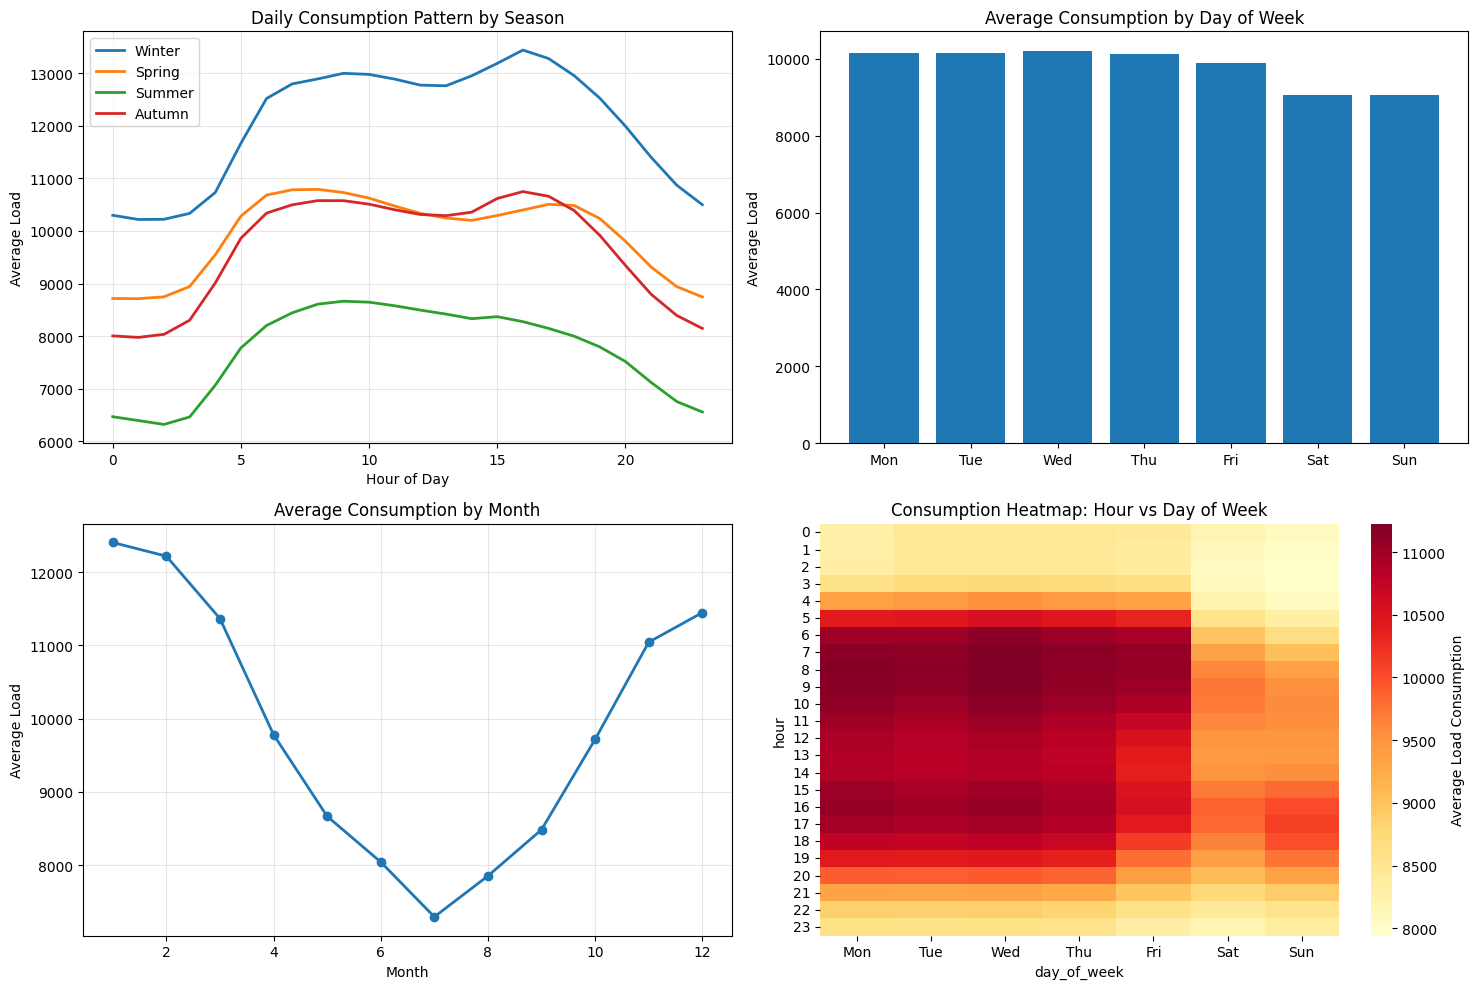

===Key Insights Consumption===
- Peak Consumption month: 1
- Lowest Consumption month: 7
- Highest Consumption day: Wed
- Lowest Consumption day: Sun
- Peak Consumption hour: 09:00
- Lowest Consumption hour: 01:00


In [32]:
season_analysis(df_imp, 'load_actual', 'Consumption')

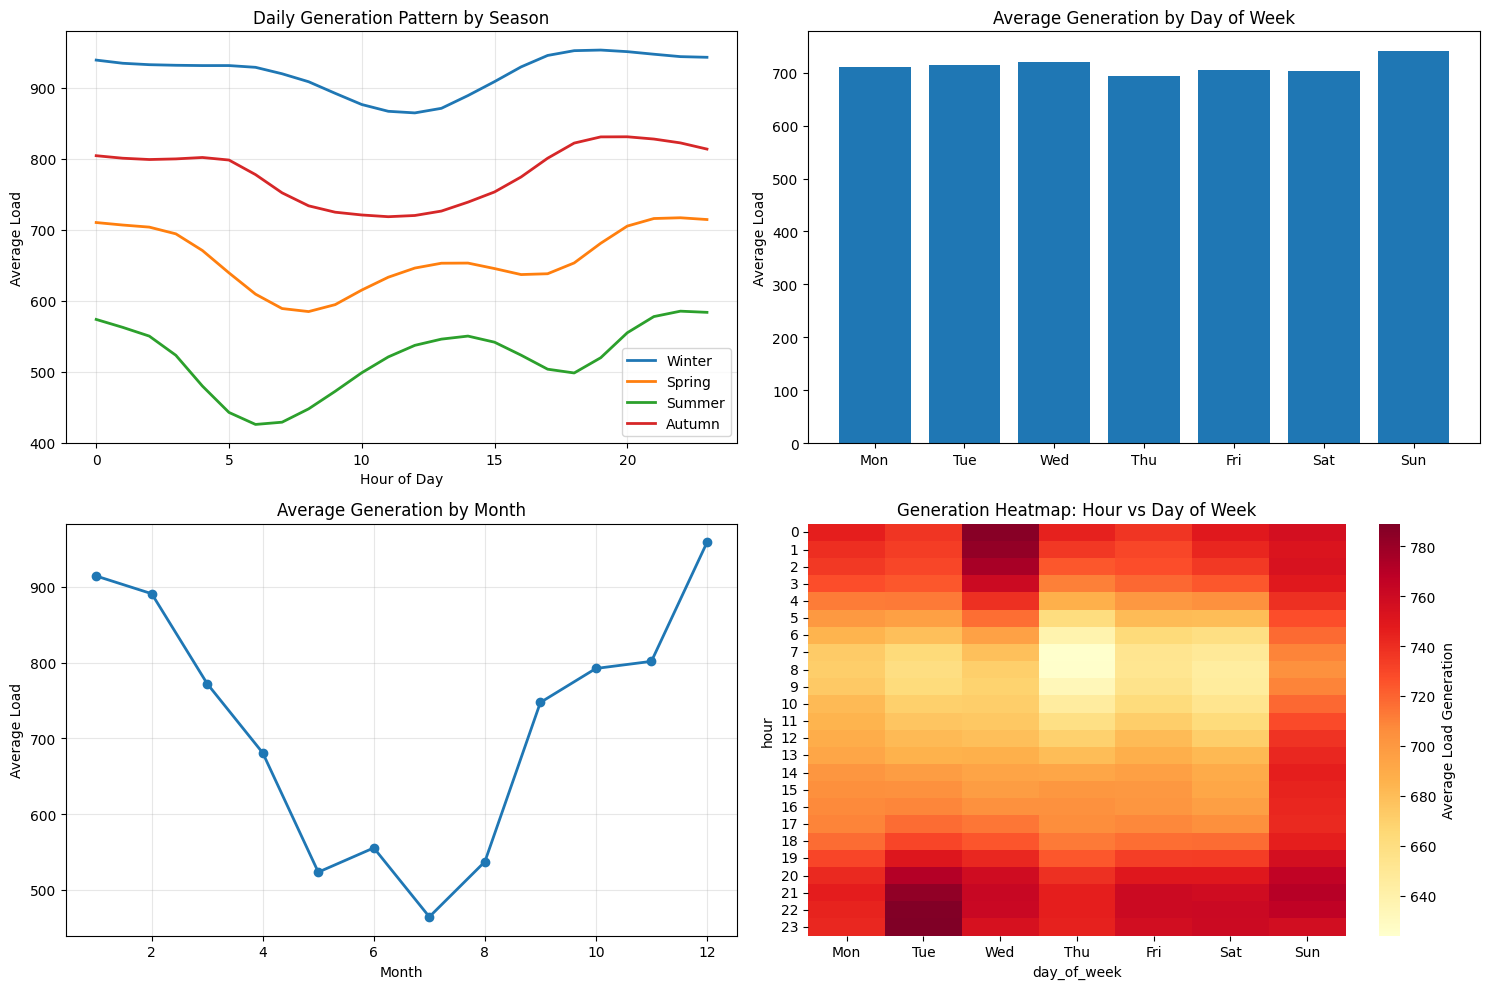

===Key Insights Generation===
- Peak Generation month: 12
- Lowest Generation month: 7
- Highest Generation day: Sun
- Lowest Generation day: Thu
- Peak Generation hour: 22:00
- Lowest Generation hour: 08:00


In [33]:
season_analysis(df_imp, 'load_generation', 'Generation')

## Forecast

Outline:
1. Train-test split
2. SARIMAX
3. N-BEATS
4. LSTM Forecasting
5. Timeseries Classification with Rocket

**For simplicity, we'll use 'load_actual' as the target. However, it's possible to modify the code based on the needs.**

### 0. Evaluation

For comparison between model

In [11]:
def evaluate_forecasts(predictions, actuals, model_name="Model"):
    """
    Evaluate forecasting performance
    """
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_forecasts(predictions, actuals, model_name="Model", n_show=24*7):
    """
    Plot forecast results
    """
    plt.figure(figsize=(15, 6))

    # Show only first n_show points for clarity
    show_pred = predictions[:n_show]
    show_actual = actuals[:n_show]

    plt.plot(show_actual, label='Actual', linewidth=2)
    plt.plot(show_pred, label=f'{model_name} Prediction', linewidth=2, alpha=0.8)
    plt.title(f'{model_name} Forecast vs Actual')
    plt.xlabel('Hours')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 1. Train-test split

Estimation: <br>
Training: 70% (2015 - mid 2018) <br>
Validation: 10% (mid 2018 - early 2019) <br>
Test: 20% (early 2019 - 2020) <br>

In [12]:
class TimeSeriesTrainTest:
    """
    Proper time series data splitting and preparation
    """

    def __init__(self, df, target_col='load_actual', test_size=0.3, val_size=0.1):
        self.df = df.copy()
        self.target_col = target_col
        self.test_size = test_size
        self.val_size = val_size

    def temporal_split(self):
        """
        Split data temporally, respect the sequence
        """

        total_len = len(self.df)

        # Calculate split points
        train_end = int(total_len * (1 - self.test_size - self.val_size))
        val_end = int(total_len * (1 - self.test_size))

        # Split the data
        train_data = self.df.iloc[:train_end]
        val_data = self.df.iloc[train_end:val_end]
        test_data = self.df.iloc[val_end:]

        print(f"Training data: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} points)")
        print(f"Validation data: {val_data.index[0]} to {val_data.index[-1]} ({len(val_data)} points)")
        print(f"Test data: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} points)")

        # Visualize split
        plt.figure(figsize=(15, 6))
        plt.plot(train_data.index, train_data[self.target_col], label='Train', alpha=0.7)
        plt.plot(val_data.index, val_data[self.target_col], label='Validation', alpha=0.7)
        plt.plot(test_data.index, test_data[self.target_col], label='Test', alpha=0.7)
        plt.title('Time Series Data Split')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return train_data, val_data, test_data

    def create_sequences(self, data, lookback_window=None, forecast_horizon=24):
        """
        Create sequences for deep learning models
        """
        if lookback_window is None:
            lookback_window = 24*7

        X, y = [], []

        for i in range(lookback_window, len(data) - forecast_horizon + 1):
            # Features: past 'lookback_window' hours
            X.append(data.iloc[i-lookback_window:i].values)
            # Target: next 'forecast_horizon' hours
            y.append(data[self.target_col].iloc[i:i+forecast_horizon].values)

        return np.array(X), np.array(y)

Training data: 2015-01-05 00:00:00+00:00 to 2018-06-15 13:00:00+00:00 (30182 points)
Validation data: 2018-06-15 14:00:00+00:00 to 2019-01-11 03:00:00+00:00 (5030 points)
Test data: 2019-01-11 04:00:00+00:00 to 2020-09-30 23:00:00+00:00 (15092 points)


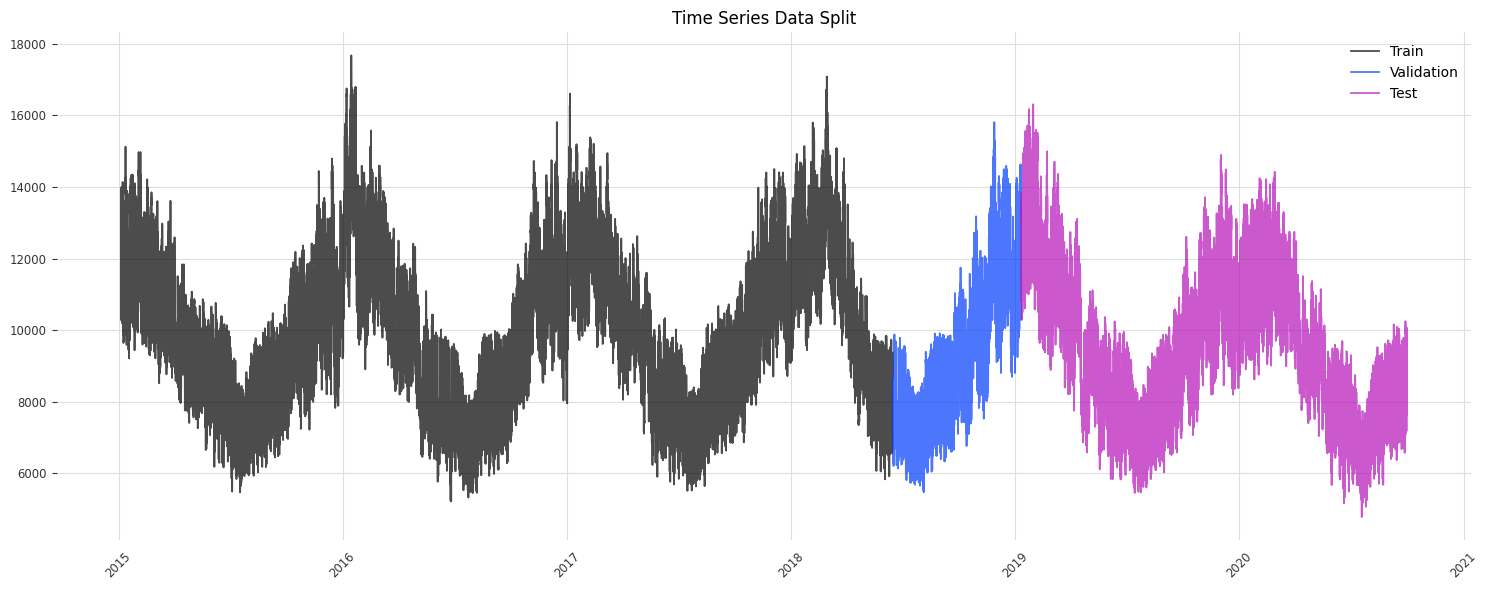

In [13]:
data_handler_imp = TimeSeriesTrainTest(df_imp, target_col='load_actual')
train_data_imp, val_data_imp, test_data_imp = data_handler_imp.temporal_split()

### 2. SARIMAX

Statistical model, good baseline, captures trends/seasonality. Since the electricity data has some kind of cycle, we use SARIMAX as the baseline.

In [16]:
class SARIMAXForecast:
    """
    SARIMAX model for time series forecasting
    """

    def __init__(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.model = None
        self.model_fit = None
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, train_data, target_col='load_actual'):
        """
        Fit SARIMAX model
        """
        series = train_data[target_col].dropna()

        # Fit model
        self.model = SARIMAX(
            series,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
            )

        self.model_fit = self.model.fit(disp=False)

        print(self.model_fit.summary())

        print("Training SARIMAX done")
        return self

    def forecast_rolling(self, test_data, target_col='load_actual', forecast_horizon=24):
        """
        Rolling forecast (refit model for each prediction)
        """
        print(f"SARIMAX Rolling Forecast (horizon: {forecast_horizon} hours)")

        predictions = []
        actuals = []

        # Get initial training data
        history = list(self.model_fit.model.endog)

        # Use the original fitted model initially
        current_model_fit = self.model_fit

        total_steps = len(test_data) - forecast_horizon + 1
        step_size = forecast_horizon  # Can be adjusted for different strategies

        start_time = time.time()

        for i in range(0, total_steps, step_size):
            step_start_time = time.time()

            # Refit model every 7 days: balances accuracy and computational efficiency
            if i > 0 and i % (24 * 7) == 0:
                model = SARIMAX(
                    history,
                    order=self.order,
                    seasonal_order=self.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                current_model_fit = model.fit(disp=False, maxiter=50)

            forecast = current_model_fit.forecast(steps=min(forecast_horizon, len(test_data) - i))
            predictions.extend(forecast)

            # Get actual values
            actual = test_data[target_col].iloc[i:i+forecast_horizon].values
            actuals.extend(actual[:len(forecast)])  # Match forecast length

            # Update history with actual values for next iteration
            history.extend(actual[:len(forecast)])

            step_time = time.time() - step_start_time
            elapsed_time = time.time() - start_time

            if i % (forecast_horizon * 7) == 0:  # Print progress every week
                progress = (i + forecast_horizon) / len(test_data) * 100
                estimated_total = elapsed_time / max((i + forecast_horizon), 1) * len(test_data)
                remaining = estimated_total - elapsed_time

                print(f"Forecasted {i + forecast_horizon} / {len(test_data)} hours")
                print(f"\n| Step time: {step_time:.2f}s | ETA: {remaining/60:.1f}min")

        return np.array(predictions), np.array(actuals)

    def forecast_rolling_simple(self, test_data, target_col='load_actual', forecast_horizon=24): # much faster
        """
        Simpler rolling forecast without refitting (much faster)
        """
        print(f"SARIMAX Simple Rolling Forecast (horizon: {forecast_horizon} hours)")

        predictions = []
        actuals = []

        # Get the end of training data for extending
        last_obs = self.model_fit.model.endog

        for i in range(0, len(test_data) - forecast_horizon + 1, forecast_horizon):
            # Simple forecast from the original model
            forecast = self.model_fit.forecast(steps=forecast_horizon)
            predictions.extend(forecast)

            # Get actual values
            actual = test_data[target_col].iloc[i:i+forecast_horizon].values
            actuals.extend(actual)

            if i % (forecast_horizon * 7) == 0:  # Progress every week
                progress = (i + forecast_horizon) / len(test_data) * 100
                print(f"Progress: {progress:.1f}% ({i + forecast_horizon}/{len(test_data)} hours)")

        return np.array(predictions), np.array(actuals)

    def forecast_simple(self, n_periods=24):
        """
        Simple forecast without rolling
        """
        return self.model_fit.forecast(steps=n_periods)

In [17]:
def run_sarimax_forecast():
    try:
        print("Initializing SARIMAX model...")
        sarimax_model = SARIMAXForecast(order=(1,1,1), seasonal_order=(1,1,1,24))

        print("Fitting SARIMAX model...")
        sarimax_model.fit(train_data_imp, target_col='load_actual')

        print("Starting rolling forecast...")
        # Try the simpler version first (much faster)
        sarimax_pred, sarimax_actual = sarimax_model.forecast_rolling_simple(
            test_data_imp, target_col='load_actual', forecast_horizon=24
        )

        # If you need the more sophisticated rolling forecast with refitting:
        # sarimax_pred, sarimax_actual = sarimax_model.forecast_rolling(
        #     test_data_imp, target_col='load_actual', forecast_horizon=24
        # )

        print("Evaluating forecasts...")
        sarimax_metrics = evaluate_forecasts(sarimax_pred, sarimax_actual, "SARIMAX")

        print("Plotting results...")
        plot_forecasts(sarimax_pred, sarimax_actual, "SARIMAX")

        return sarimax_model, sarimax_pred, sarimax_actual, sarimax_metrics

    except Exception as e:
        print(f"Error in SARIMAX forecast: {e}")
        return None, None, None, None

Initializing SARIMAX model...
Fitting SARIMAX model...
                                     SARIMAX Results                                      
Dep. Variable:                        load_actual   No. Observations:                30182
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -195393.040
Date:                            Fri, 12 Sep 2025   AIC                         390796.081
Time:                                    09:19:01   BIC                         390837.647
Sample:                                01-05-2015   HQIC                        390809.415
                                     - 06-15-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2097      0.007     27.962      0.000     

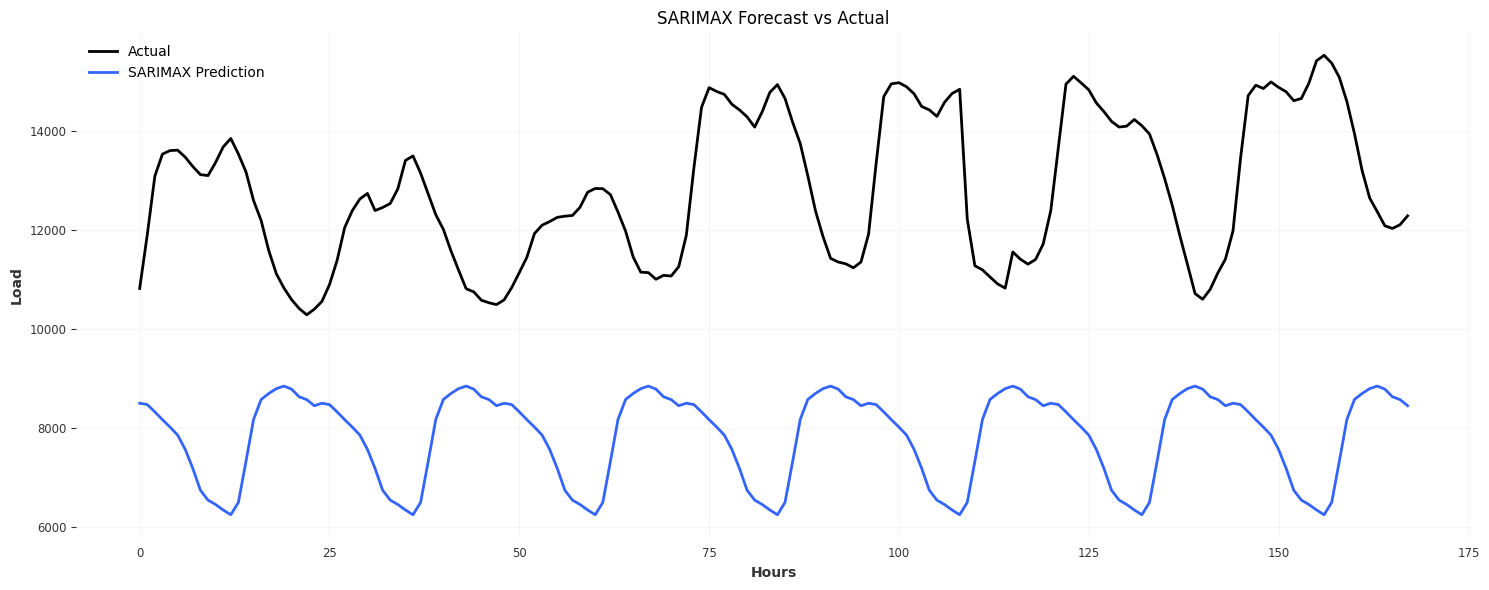

In [18]:
# Run the forecast
sarimax_model, sarimax_pred, sarimax_actual, sarimax_metrics = run_sarimax_forecast()

### 3. N-BEATS: Neural network designed for forecasting, handles complex patterns

*Using KERAS*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

In [32]:
class NBEATSForecast:
    """
    N-BEATS neural network for forecasting using Darts wrapper
    """

    def __init__(self,
                 input_chunk_length=24*7,
                 output_chunk_length=24,
                 num_stacks=30,
                 num_blocks=1,
                 num_layers=4,
                 layer_widths=512,
                 dropout=0.1):

        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length

        self.model = NBEATSModel(
            input_chunk_length=input_chunk_length,
            output_chunk_length=output_chunk_length,
            num_stacks=num_stacks,
            num_blocks=num_blocks,
            num_layers=num_layers,
            layer_widths=layer_widths,
            expansion_coefficient_dim=5,
            trend_polynomial_degree=2,
            dropout=dropout,
            activation="ReLU",
            random_state=42,
            pl_trainer_kwargs={
                "accelerator": "auto",
                "devices": 1,
                "enable_progress_bar": True,
                "max_epochs": 100
            }
        )

    def fit(self, train_data, val_data, target_col='load_actual', epochs=30): # Reduced epoch for demo
        """
        Train N-BEATS model
        """
        print("Training N-BEATS")

        # Prepare data
        train_data = train_data.copy()
        val_data = val_data.copy()

        # Remove timezone info to avoid warnings
        if hasattr(train_data.index, 'tz') and train_data.index.tz is not None:
            train_data.index = train_data.index.tz_localize(None)
        if hasattr(val_data.index, 'tz') and val_data.index.tz is not None:
            val_data.index = val_data.index.tz_localize(None)

        # Convert to Darts TimeSeries (only target column)
        train_ts = TimeSeries.from_dataframe(
            train_data[[target_col]],
            value_cols=target_col
        )

        val_ts = TimeSeries.from_dataframe(
            val_data[[target_col]],
            value_cols=target_col
        )

        # Update the trainer kwargs before fitting
        if hasattr(self.model, 'pl_trainer_kwargs'):
            self.model.pl_trainer_kwargs['max_epochs'] = epochs
        else:
            # For older versions of Darts, recreate the model with updated epochs
            self.model = NBEATSModel(
                input_chunk_length=self.input_chunk_length,
                output_chunk_length=self.output_chunk_length,
                num_stacks=30,
                num_blocks=1,
                num_layers=4,
                layer_widths=512,
                expansion_coefficient_dim=5,
                trend_polynomial_degree=2,
                dropout=0.1,
                activation="ReLU",
                random_state=42,
                pl_trainer_kwargs={
                    "accelerator": "auto",
                    "devices": 1,
                    "enable_progress_bar": True,
                    "max_epochs": epochs
                }
            )

        self.model.fit(
            series=train_ts,
            val_series=val_ts,
            verbose=True
        )

        print("Darts N-BEATS model trained successfully")

        return self

    def forecast_rolling(self, test_data, target_col='load_actual', train_tail=None):
        """
        Rolling forecast with N-BEATS
        """
        print("=== N-BEATS Rolling Forecast ===")

        test_data = test_data.copy()

        # Ensure datetime index
        if not isinstance(test_data.index, pd.DatetimeIndex):
            test_data.index = pd.to_datetime(test_data.index)

        # Convert to Darts TimeSeries
        test_ts = TimeSeries.from_dataframe(
            test_data.reset_index(),
            time_col=test_data.index.name or 'time',
            value_cols=target_col
        )

        # Prepare historical context
        historical_ts = None
        if train_tail is not None:
            train_tail = train_tail.copy()

            # Take only the last part of training data that we need for context
            context_length = max(self.input_chunk_length, 24*14)  # At least 2 weeks
            if len(train_tail) > context_length:
                train_tail = train_tail.tail(context_length)

            # Ensure datetime index
            if not isinstance(train_tail.index, pd.DatetimeIndex):
                train_tail.index = pd.to_datetime(train_tail.index)

            historical_ts = TimeSeries.from_dataframe(
                train_tail.reset_index(),
                time_col=train_tail.index.name or 'time',
                value_cols=target_col
            )


        predictions = []
        actuals = []

        # Rolling forecast
        n_forecasts = len(test_data) // self.output_chunk_length

        for i in range(n_forecasts):
            start_idx = i * self.output_chunk_length
            end_idx = min(start_idx + self.output_chunk_length, len(test_data))

            print(f"Forecast {i+1}/{n_forecasts}: predicting steps {start_idx} to {end_idx-1}")

            # Prepare context series for prediction
            if historical_ts is not None:
                if start_idx == 0:
                    # First prediction: use historical context
                    context_series = historical_ts
                else:
                    # Subsequent predictions: use historical + previous test data
                    previous_test_data = test_data.iloc[:start_idx]
                    previous_test_ts = TimeSeries.from_dataframe(
                        previous_test_data.reset_index(),
                        time_col=previous_test_data.index.name or 'time',
                        value_cols=target_col
                    )
                    context_series = historical_ts.concatenate(previous_test_ts)
            else:
                # No historical context - use available test data
                if start_idx < self.input_chunk_length:
                    print(f"Warning: Not enough context for prediction {i+1}. Skipping.")
                    continue

                context_data = test_data.iloc[:start_idx]
                context_series = TimeSeries.from_dataframe(
                    context_data.reset_index(),
                    time_col=context_data.index.name or 'time',
                    value_cols=target_col
                )

            # Check if we have enough context
            if len(context_series) < self.input_chunk_length:
                print(f"Warning: Insufficient context length {len(context_series)} < {self.input_chunk_length}")
                continue

            # Make prediction
            n_predict = end_idx - start_idx
            forecast = self.model.predict(
                n=n_predict,
                series=context_series
            )

            pred_values = forecast.values().flatten()
            predictions.extend(pred_values)

            # Get actual values
            actual_values = test_data[target_col].iloc[start_idx:end_idx].values
            actuals.extend(actual_values)

        print(f"Generated {len(predictions)} predictions and {len(actuals)} actuals")
        return np.array(predictions), np.array(actuals)

    def forecast_simple(self, test_data, target_col='load_actual', n_periods=24):
        """
        Simple forecast for n_periods ahead
        """
        print(f"N-BEATS Simple Forecast ({n_periods} periods)")

        test_data = test_data.copy()
        if not isinstance(test_data.index, pd.DatetimeIndex):
            test_data.index = pd.to_datetime(test_data.index)

        # Use the last part of test_data as context
        context_length = min(self.input_chunk_length, len(test_data))
        context_data = test_data.tail(context_length)

        context_ts = TimeSeries.from_dataframe(
            context_data.reset_index(),
            time_col=context_data.index.name or 'time',
            value_cols=target_col
        )

        forecast = self.model.predict(n=n_periods, series=context_ts)
        return forecast.values().flatten()


In [33]:
def run_nbeats_forecast():
    """
    Run N-BEATS forecast with error handling
    """
    try:
        print("Initializing N-BEATS model...")
        nbeats_model = NBEATSForecast(
            input_chunk_length=24*7,
            output_chunk_length=24
        )

        print("Fitting N-BEATS model...")
        nbeats_model.fit(
            train_data_imp,
            val_data_imp,
            target_col='load_actual',
            epochs=30
        )

        print("Starting rolling forecast...")
        nbeats_pred, nbeats_actual = nbeats_model.forecast_rolling(
            test_data_imp,
            target_col='load_actual',
            train_tail=train_data_imp
        )

        if len(nbeats_pred) > 0 and len(nbeats_actual) > 0:
            print("Evaluating forecasts...")
            nbeats_metrics = evaluate_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")

            print("Plotting results...")
            plot_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")

            return nbeats_model, nbeats_pred, nbeats_actual, nbeats_metrics
        else:
            print("No predictions generated!")
            return None, None, None, None

    except Exception as e:
        print(f"Error in N-BEATS forecast: {e}")
        print(f"Error type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

In [34]:
nbeats_model, nbeats_pred, nbeats_actual, nbeats_metrics = run_nbeats_forecast()

Initializing N-BEATS model...
Fitting N-BEATS model...
Training N-BEATS


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 26.4 M | train
-------------------------------------------------------------
26.4 M    Trainable params
3.6 K     Non-trainable params
26.4 M    Total params
211.387   Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Darts N-BEATS model trained successfully
Starting rolling forecast...
=== N-BEATS Rolling Forecast ===
Error in N-BEATS forecast: Cannot interpret 'datetime64[ns, UTC]' as a data type
Error type: TypeError


Traceback (most recent call last):
  File "/tmp/ipython-input-972906886.py", line 21, in run_nbeats_forecast
    nbeats_pred, nbeats_actual = nbeats_model.forecast_rolling(
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1152910615.py", line 125, in forecast_rolling
    historical_ts = TimeSeries.from_dataframe(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/darts/timeseries.py", line 669, in from_dataframe
    if np.issubdtype(time_col_vals.dtype, object):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/numpy/core/numerictypes.py", line 417, in issubdtype
    arg1 = dtype(arg1).type
           ^^^^^^^^^^^
TypeError: Cannot interpret 'datetime64[ns, UTC]' as a data type


### LSTM: RNN for sequential data, captures long-term dependencies

*Using KERAS/TF LSTM*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

This model utilize "multi-steps" (forecast_horizon). Comparison between single step and multi steps:<br>
**1. One-step-ahead prediction (recursive / iterated)**
How it works:
- Model predicts one timestep ahead.
- Feed that prediction as input to predict the next timestep.
- Repeat until you reach your forecast horizon.

Pros:
- Simpler model — only needs to learn one-step dynamics.
- Often easier to train, less prone to exploding errors in training.
- Works well if the series is smooth or stationary.

Cons:
- Errors accumulate (propagate) over multiple steps — a small mistake in early predictions can ruin later steps.
- Prediction distribution may drift from reality over long horizons.

Use case:
- Short-term forecasts.
- When the system dynamics are fairly stable and predictable.

**2. Multi-step prediction at each step (direct + rolling)**
How it works:
- Model predicts multiple steps at each time step, potentially with overlapping windows.
- Can be thought of as a hybrid: each forecast covers multiple steps, but you also move forward in time.

Pros:
- Balances flexibility and horizon coverage.
- Can learn inter-step correlations better than simple recursive one-step.

Cons:
- Even harder to train.
- Can be computationally expensive if horizon is long.

In [39]:
class LSTMForecast:
    """
    LSTM model for time series forecasting
    """

    def __init__(self, lookback_window=24*7, forecast_horizon=24):
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.scaler = StandardScaler()
        self.target_scaler = StandardScaler()

    def create_model(self, input_dim):
        """
        Create LSTM model
        """

        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.lookback_window, input_dim)),
            Dropout(0.2),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(self.forecast_horizon)
        ])

        model.compile(optimizer=Adam(learning_rate=0.0005,
                                     clipnorm=1.0), # gradient clipping
                     loss='mse',
                     metrics=['mae']
                     )

        return model

    def fit(self, train_data, val_data, target_col='load_actual', epochs=50):
        """
        Train LSTM model
        """
        print("=== TRAINING LSTM MODEL ===")

        # Create sequences
        data_handler = TimeSeriesTrainTest(pd.concat([train_data, val_data]))
        X_train, y_train = data_handler.create_sequences(
            train_data, self.lookback_window, self.forecast_horizon
        )
        X_val, y_val = data_handler.create_sequences(
            val_data, self.lookback_window, self.forecast_horizon
        )

        target_col_idx = list(train_data.columns).index(target_col)
        feature_indices = [i for i in range(len(train_data.columns)) if i != target_col_idx]

        X_train = X_train[:, :, feature_indices]
        X_val = X_val[:, :, feature_indices]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

        # Scale target - fix the reshaping issue
        y_train_flat = y_train.reshape(-1, 1)
        y_val_flat = y_val.reshape(-1, 1)

        self.target_scaler.fit(y_train_flat)
        y_train_scaled = self.target_scaler.transform(y_train_flat).reshape(y_train.shape)
        y_val_scaled = self.target_scaler.transform(y_val_flat).reshape(y_val.shape)

        # Create and train model
        self.model = self.create_model(X_train.shape[-1])

        callbacks = [
            EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(patience=7, factor=0.7, min_lr=1e-7),
            ModelCheckpoint('lstm_best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
        ]

        history = self.model.fit(X_train_scaled, y_train_scaled,
                                 validation_data=(X_val_scaled, y_val_scaled),
                                 epochs=epochs,
                                 batch_size=64,
                                 verbose=1,
                                 callbacks=callbacks)

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('LSTM Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train')
        plt.plot(history.history['val_mae'], label='Validation')
        plt.title('LSTM MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return self

    def forecast_rolling(self, test_data, target_col='load_actual', train_tail=None):
        """
        Rolling forecast with LSTM
        """
        print("=== LSTM ROLLING FORECAST ===")

        predictions = []
        actuals = []

        # Remove target column from features
        feature_cols = [col for col in test_data.columns if col != target_col]

        # If train_tail is provided, use it for initial context
        if train_tail is not None:
            initial_context = train_tail[feature_cols].iloc[-self.lookback_window:]
        else:
            initial_context = None

        for i in range(0, len(test_data) - self.forecast_horizon + 1, self.forecast_horizon):
            # Prepare input sequence
            if i == 0 and initial_context is not None:
                lookback_data = initial_context
            elif i < self.lookback_window:
                # Not enough history yet, skip
                continue
            else:
                # Use sliding window from test data
                lookback_data = test_data[feature_cols].iloc[i-self.lookback_window:i]

            # Ensure enough rows / safety check
            if len(lookback_data) < self.lookback_window:
                print(f"Warning: Insufficient lookback data at step {i}")
                continue

            # Check for NaN values
            if lookback_data.isnull().any().any():
                print(f"Warning: NaN values detected at step {i}")
                continue

            X_pred = lookback_data.values.reshape(1, self.lookback_window, -1)
            X_pred_scaled = self.scaler.transform(X_pred.reshape(-1, X_pred.shape[-1])).reshape(X_pred.shape)

            # Make prediction
            pred_scaled = self.model.predict(X_pred_scaled, verbose=0)[0]
            pred = self.target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1)
            predictions.extend(pred)

            # Get actual values
            actual = test_data[target_col].iloc[i:i+self.forecast_horizon].values
            actuals.extend(actual)

        return np.array(predictions), np.array(actuals)

In [ ]:
lstm_model = LSTMForecast()
lstm_model.fit(train_data_imp, val_data_imp, target_col='load_actual', epochs=30) # Reduced for demo
lstm_pred, lstm_actual = lstm_model.forecast_rolling(test_data_imp, target_col='load_actual', train_tail=train_data_imp)
lstm_metrics = evaluate_forecasts(lstm_pred, lstm_actual, "LSTM")
plot_forecasts(lstm_pred, lstm_actual, "LSTM")

=== TRAINING LSTM MODEL ===
Epoch 1/30


### Rocket: Fast time series classification using random convolutions

*Identify consumption patterns (High/Medium/Low usage periods)*

In [45]:
class TimeSeriesClassifier:
    """
    Time series classification using ROCKET
    """

    def __init__(self, window_size=24*7):
        self.window_size = window_size
        self.rocket = None
        self.classifier = None
        self.label_encoder = None
        self.percentile_25 = None # For training data only, if not provided will be computed below
        self.percentile_75 = None # For training data only, if not provided will be computed below

    def create_classification_data(self, df, target_col='load_actual', train_percentiles=None):
        """
        Create classification dataset from time series
        Example: Classify consumption patterns (High/Medium/Low)
        """
        print("=== CREATING CLASSIFICATION DATASET ===")

        X_class = []
        y_class = []

        # If train_percentiles not provided, compute them (this should only happen for training data)
        if train_percentiles is None:
            self.percentile_25 = np.percentile(df[target_col], 25)
            self.percentile_75 = np.percentile(df[target_col], 75)
        else:
            # Use provided percentiles (for validation/test data)
            self.percentile_25, self.percentile_75 = train_percentiles

        for i in range(0, len(df) - self.window_size + 1, self.window_size):
            # Get window of data
            window = df[target_col].iloc[i:i+self.window_size].values

            # Create label based on average consumption / self-define
            avg_consumption = np.mean(window)
            if avg_consumption > self.percentile_75:
                label = 'High'
            elif avg_consumption > self.percentile_25:
                label = 'Medium'
            else:
                label = 'Low'

            X_class.append(window)
            y_class.append(label)

        print(f"Created {len(X_class)} classification samples")
        print(f"Class distribution: \n{pd.Series(y_class).value_counts()}")

        return np.array(X_class), np.array(y_class)

    def fit_rocket(self, X_train, y_train):
        """
        Train ROCKET classifier
        """
        print("Training ROCKET Classifier")

        # Initialize ROCKET
        self.rocket = Rocket()

        # Fit ROCKET and transform training data
        X_train_rocket = X_train[:, np.newaxis, :]  # shape (n_samples, 1, window_size)
        X_rocket = self.rocket.fit_transform(X_train_rocket)

        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y_train)

        # Train classifier
        self.classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        self.classifier.fit(X_rocket, y_encoded)

        print("ROCKET classifier trainng done")
        print(f"Feature dimension after ROCKET: {X_rocket.shape[1]}")

    def predict(self, X_test):
        """
        Make predictions
        """

        # ROCKET predictions
        X_rocket = self.rocket.transform(X_test[:, np.newaxis, :])
        predictions = self.classifier.predict(X_rocket)

        return self.label_encoder.inverse_transform(predictions)

In [46]:
# Split the timeseries into train and test
train_ratio = 0.8
target_col = 'load_actual'
n_train = int(len(df_imp) * train_ratio)
train_df = df_imp.iloc[:n_train].copy()
test_df = df_imp.iloc[n_train:].copy()

classifier = TimeSeriesClassifier(window_size=24*7)
X_train_class, y_train_class = classifier.create_classification_data(
    train_df, target_col=target_col)

# 5. Create test classification data using TRAINING percentiles
X_test_class, y_test_class = classifier.create_classification_data(
    test_df, target_col=target_col, train_percentiles=train_percentiles
)
classifier.fit_rocket(X_train_class, y_train_class)
class_pred = classifier.predict(X_test_class)

print("Classification Results:")
print(classification_report(y_test_class, class_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, class_pred))

=== CREATING CLASSIFICATION DATASET ===
Created 299 classification samples
Class distribution: 
Medium    154
High       81
Low        64
Name: count, dtype: int64
=== TRAINING ROCKET CLASSIFIER ===
ROCKET classifier trained successfully
Classification Results:
              precision    recall  f1-score   support

        High       0.65      1.00      0.79        13
         Low       0.91      0.62      0.74        16
      Medium       0.79      0.74      0.77        31

    accuracy                           0.77        60
   macro avg       0.78      0.79      0.77        60
weighted avg       0.79      0.77      0.76        60



## Conclusion

In [47]:
comparison = pd.DataFrame({
        'Model': ['ARIMA', 'N-BEATS', 'LSTM'],
        'MAE': [sarimax_metrics['MAE'], nbeats_metrics['MAE'], lstm_metrics['MAE']],
        'RMSE': [sarimax_metrics['RMSE'], nbeats_metrics['RMSE'], lstm_metrics['RMSE']],
        'MAPE': [sarimax_metrics['MAPE'], nbeats_metrics['MAPE'], lstm_metrics['MAPE']]
    })

print("Final Comparison")
print(comparison)

Final Comparison
     Model          MAE         RMSE       MAPE
0    ARIMA  2000.523130  2555.775138  19.295518
1  N-BEATS  1088.391166  1437.140726  11.931456
2     LSTM  1397.358976  1764.286689  15.188411
